<a href="https://colab.research.google.com/github/ghulam2545/deep_learning/blob/main/project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import Model

In [3]:
print('GPU is available' if tf.config.list_physical_devices('GPU') else 'GPU is not available')

GPU is available


In [4]:
train_dir = '/content/drive/MyDrive/dataset/chest_xray/train'
test_dir = '/content/drive/MyDrive/dataset/chest_xray/test'

In [22]:
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [6]:
test_generator = ImageDataGenerator(
    rescale = 1. / 255
)

In [7]:
img_dim = (224, 224)
batch_size = 32
train_steps_per_epoch = 100
valid_steps_per_epoch = 50

In [23]:
train_ds = train_generator.flow_from_directory(
    train_dir,
    target_size=img_dim,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training'
)

Found 4131 images belonging to 2 classes.


In [24]:
val_ds = train_generator.flow_from_directory(
    train_dir,
    target_size=img_dim,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='validation'
)

Found 1032 images belonging to 2 classes.


In [9]:
test_ds = test_generator.flow_from_directory(
    test_dir,
    target_size=img_dim,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 613 images belonging to 2 classes.


In [10]:
x_train, y_train = train_ds.next() # Getting a batch of training samples

print("Training dataset shape:")
print(x_train.shape) # Shape of the input images (batch_size, height, width, channels)
print(y_train.shape) # Shape of the corresponding labels (batch_size,)

Training dataset shape:
(32, 224, 224, 3)
(32,)


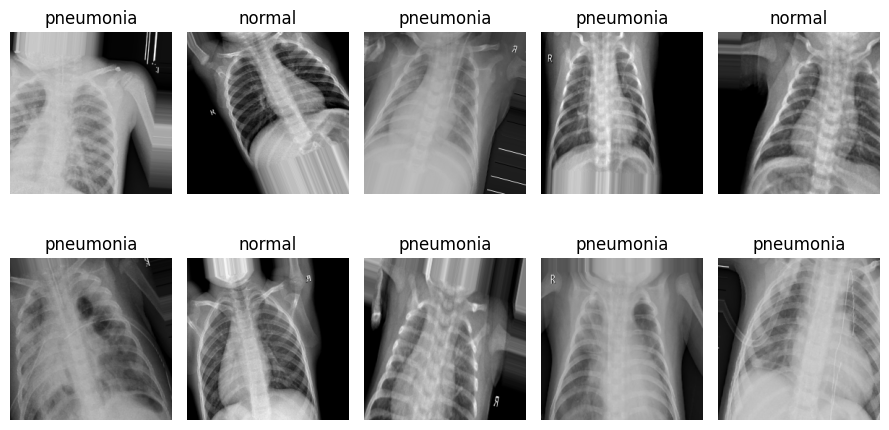

In [11]:
plt.figure(figsize=(9, 5))
for i in range(2 * 5):
  plt.subplot(2, 5, i + 1)
  plt.imshow(x_train[i])
  plt.title('normal' if int(y_train[i]) == 0 else 'pneumonia')
  plt.axis('off')
plt.tight_layout()
plt.show()

In [12]:
# Load the InceptionV3 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_dim[0], img_dim[1], 3))

87910968/87910968 [==============================] - 5s 0us/step


In [13]:
# Add custom classification layers on top of the pre-trained base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

In [14]:
# Create the model
model = Model(inputs=base_model.input, outputs=output)

In [15]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [17]:
keras.utils.plot_model(model, to_file='/content/drive/MyDrive/leNet.pdf', show_shapes=True)

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_ds,
    validation_steps=valid_steps_per_epoch,
    epochs=8,
    use_multiprocessing=True
)

In [ ]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, metric in enumerate(['accuracy', 'loss']):
  ax[i].plot(history.history[metric])
  ax[i].plot(history.history['val_' + metric])
  ax[i].set_title('Model {}'.format(metric))
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel(metric)
  ax[i].legend(['Train', 'Validate'])

In [ ]:
save_location = '/content/drive/MyDrive/lenet_h5_model.h5'
model.save(save_location)